In [1]:
import sklearn
import numpy as np
import pandas as pd
import xgboost as xg
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.model_selection import train_test_split

# plt.rcParams["figure.figsize"] = (10,10)
%matplotlib inline  

In [2]:
equal_no_samples_in_each_class = False
datapath = '/home/tracek/Data/gender/gender_warbler.csv'
seed = 42

params = {'max_depth': 10,
          'n_estimators': 1000,
          'objective': 'binary:logistic',
          'eval_metric': ['auc', 'error'],
          'gamma': 0.1}

test_fraction = 0.1
val_fraction = 0.2

In [3]:
data = pd.read_csv(datapath).drop(['centroid', 'dfrange', 'filename'], axis=1) # centroid corresponds to meanfreq
male_df_len = len(data[data['label'] == 0])
female_df_len = len(data[data['label'] == 1])

In [4]:
if equal_no_samples_in_each_class:
    fraction_to_drop = 1 - female_df_len / male_df_len
    data = data.drop(data[data['label'] == 0].sample(frac=fraction_to_drop, random_state=seed).index)

In [5]:
y = data.pop('label')

In [6]:
if test_fraction > 0.0:
    X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=test_fraction, random_state=seed, stratify=y)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_fraction, random_state=seed, stratify=y_train)
    dtest = xg.DMatrix(X_test, label=y_test)
else:
    X_train, X_val, y_train, y_val = train_test_split(data, y, test_size=val_fraction, random_state=seed, stratify=y)

In [7]:
dtrain = xg.DMatrix(X_train, label=y_train)
dval = xg.DMatrix(X_val, label=y_val)
evallist = [(dval, 'eval'), (dtrain, 'train')]
model = xg.train(params=params, dtrain=dtrain, num_boost_round=100, evals=evallist, early_stopping_rounds=5)

[0]	eval-auc:0.972751	eval-error:0.044438	train-auc:0.98118	train-error:0.028359
Multiple eval metrics have been passed: 'train-error' will be used for early stopping.

Will train until train-error hasn't improved in 5 rounds.
[1]	eval-auc:0.976568	eval-error:0.039763	train-auc:0.984504	train-error:0.024572
[2]	eval-auc:0.982219	eval-error:0.038047	train-auc:0.98981	train-error:0.022412
[3]	eval-auc:0.98285	eval-error:0.037278	train-auc:0.990629	train-error:0.020149
[4]	eval-auc:0.983913	eval-error:0.03716	train-auc:0.992431	train-error:0.018093
[5]	eval-auc:0.984577	eval-error:0.036272	train-auc:0.993067	train-error:0.016317
[6]	eval-auc:0.98571	eval-error:0.035917	train-auc:0.994938	train-error:0.014956
[7]	eval-auc:0.986222	eval-error:0.035621	train-auc:0.995697	train-error:0.013359
[8]	eval-auc:0.986911	eval-error:0.035266	train-auc:0.996259	train-error:0.012486
[9]	eval-auc:0.987352	eval-error:0.035503	train-auc:0.996926	train-error:0.011524
[10]	eval-auc:0.987463	eval-error:0.035

In [8]:
y_pred_prob = model.predict(dtest)
y_pred = (y_pred_prob > 0.5).astype(int)

In [9]:
r = metrics.classification_report(y_true=y_test, y_pred=y_pred)
acc = metrics.accuracy_score(y_true=y_test, y_pred=y_pred)

In [13]:
print(r)

             precision    recall  f1-score   support

          0       0.98      0.98      0.98      7882
          1       0.92      0.89      0.90      1507

avg / total       0.97      0.97      0.97      9389



In [14]:
print('Accuracy: ', acc)

Accuracy:  0.96943231441


In [10]:
model.feature_names = [name.replace(' ', '') for name in model.feature_names]

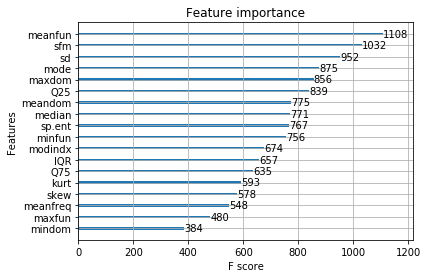

In [12]:
xg.plot_importance(model)

In [ ]:
xg.plot_tree(model, num_trees=0, rankdir='LR')
fig = plt.gcf()
fig.set_size_inches(150, 100)
fig.savefig('tree.png')

In [ ]:
import matplotlib